# GSEA analysis

In [238]:
library('fgsea')
library('msigdbr')
library('ggplot2')

In [251]:
paths <- list( 'KO-Y'='subdata/IS_results_KO::young.csv', 
               'WT-Y'='subdata/IS_results_WT::young.csv', 
               'old-Y'='subdata/IS_results_old::young.csv',
               'KO-WT'='subdata/IS_results_KO::WT.csv',
               'old-WT'='subdata/IS_results_old::WT.csv')

In [300]:
species = 'mouse'
type = 'Symbol'

#fetch gene sets
m_df_h = msigdbr(species = species, category = "H")
m_df_bp = msigdbr(species = species, category = "C5",subcategory = "BP")
m_df_kegg = msigdbr(species = species, category = "C2",subcategory = "CP:KEGG")
m_df_reactome = msigdbr(species = species, category = "C2",subcategory = "CP:REACTOME")
m_df <- rbind(rbind(m_df_h, m_df_bp,m_df_kegg),m_df_reactome)
#prepare gene sets
functions_list <- levels(factor(m_df$gs_name))
functions_annotation <- list()
for (i in functions_list){
    temp_data <- m_df[m_df$gs_name==i,]
    if (type=="Symbol"){
        temp_data <- toupper(as.character(temp_data$gene_symbol))
    }else if (type=="Entrez"){
        temp_data <- as.character(temp_data$entrez_gene)      
    }
    functions_annotation[[i]] <- temp_data
}

ds <- list()
fres <- list()
for (path in names(paths)){
    IS <- read.csv(paths[[path]])
    ranked_list <- IS[c('Name', 'ES')]
    ranked_list <- ranked_list[order(ranked_list[,2],decreasing = T),]
    ranked_vector <- ranked_list[,2]
    names(ranked_vector) <- toupper(as.character(ranked_list[,1]))
    
    res <- fgsea(pathways = functions_annotation, 
                stats    = ranked_vector,
                nperm = 10000,
                minSize  = 10,
                maxSize  = 500)
    fres[[path]] <- res
    ds[[path]] <- IS
}


Warning message in fgsea(pathways = functions_annotation, stats = ranked_vector, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (23.9% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgsea(pathways = functions_annotation, stats = ranked_vector, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (23.9% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in

NES

Using rowname as id variables

Using rowname as id variables



diff-IS

Using rowname as id variables

Using rowname as id variables



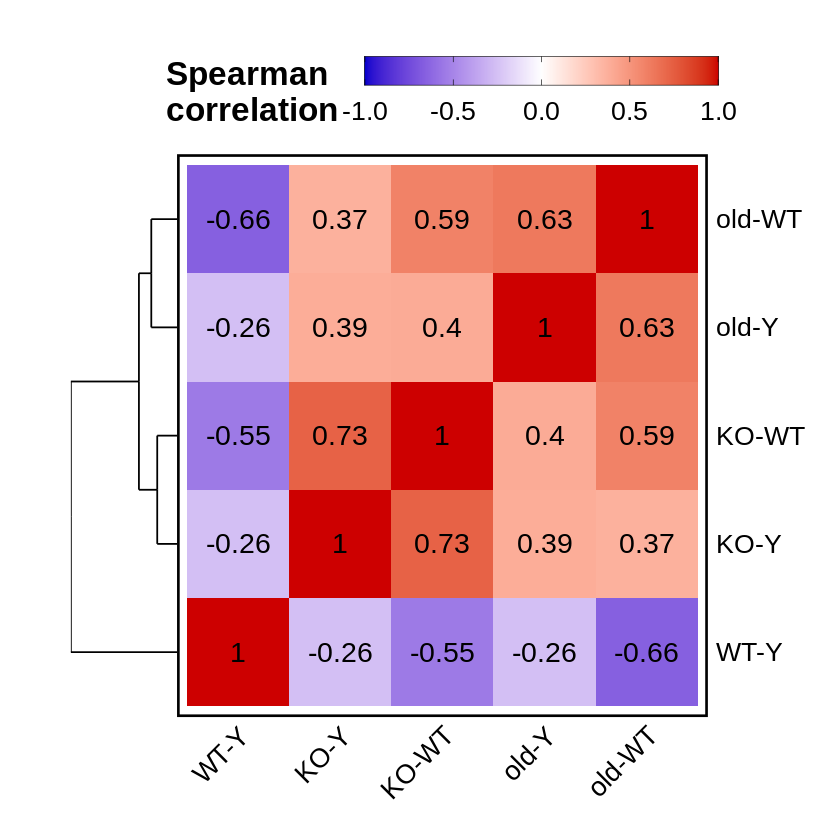

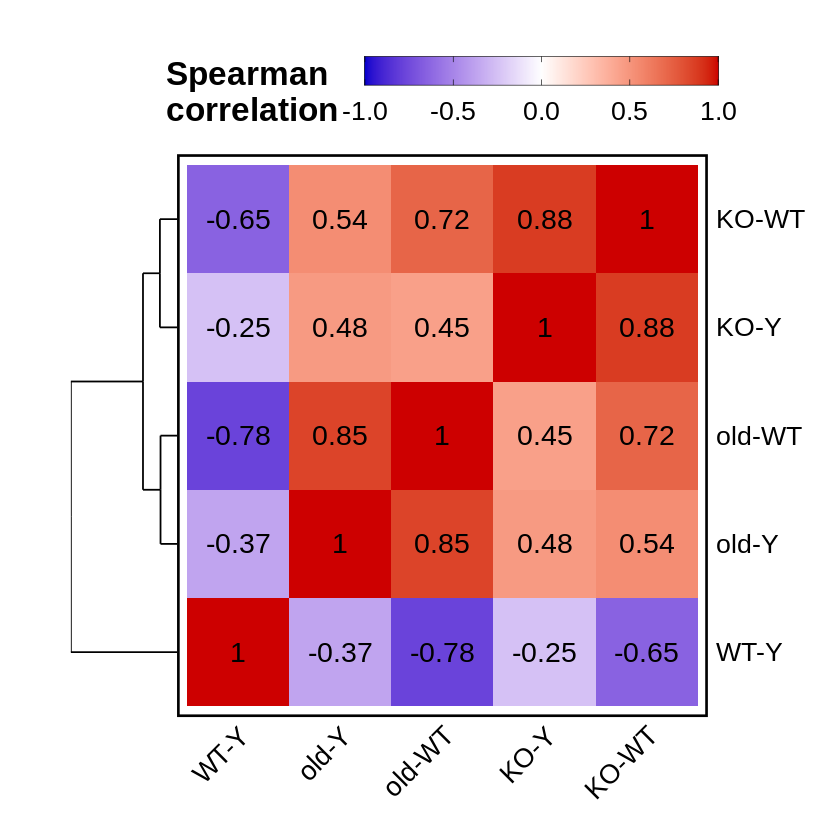

In [307]:
nesdf <- data.frame(row.names=fres[['KO-Y']]$pathway)
pdf <- data.frame(row.names=fres[['KO-Y']]$pathway)
disdf <- data.frame(row.names=ds[['KO-Y']]$Name)
for (n in names(fres)){
    disdf[n] <- ds[[n]]$FC
    nesdf[n] <- fres[[n]]$NES
    pdf[n] <- fres[[n]]$pval 
}

cat('NES')
source('utils/ggcorplot.R')
options(repr.plot.width = 7, repr.plot.height = 7)
p <- ggheatmap(nesdf)
cowplot::plot_grid(p)

cat('diff-IS')
source('utils/ggcorplot.R')
options(repr.plot.width = 7, repr.plot.height = 7)
p <- ggheatmap(disdf)
cowplot::plot_grid(p)

In [323]:
nm1 <- rownames(pdf[order(pdf[['KO-Y']]),][1:10,])
nm2 <- rownames(pdf[order(pdf[['old-Y']]),][1:10,])
nm3 <- rownames(pdf[order(pdf[['WT-Y']]),][1:10,])

nm <- unique(c(nm1, nm2, nm3))

# nm <- rownames(nesdf[sign(nesdf$old) != sign(nesdf$WT),])
# print(length(nm))
# tmp <- pdf[nm,]
# nm <- rownames(tmp[order(tmp$WT),][1:20,])

In [309]:
melt <- data.frame()
for (n in names(fres)){
    fres[[n]]$type <- n
    melt <- rbind(melt, fres[[n]])
}

In [324]:
#submelt <- melt[grepl('HALLMARK', melt$pathway),]
submelt <- melt[melt$pathway %in% nm,]

In [325]:
submelt$pathway <- factor(submelt$pathway, levels=nm)

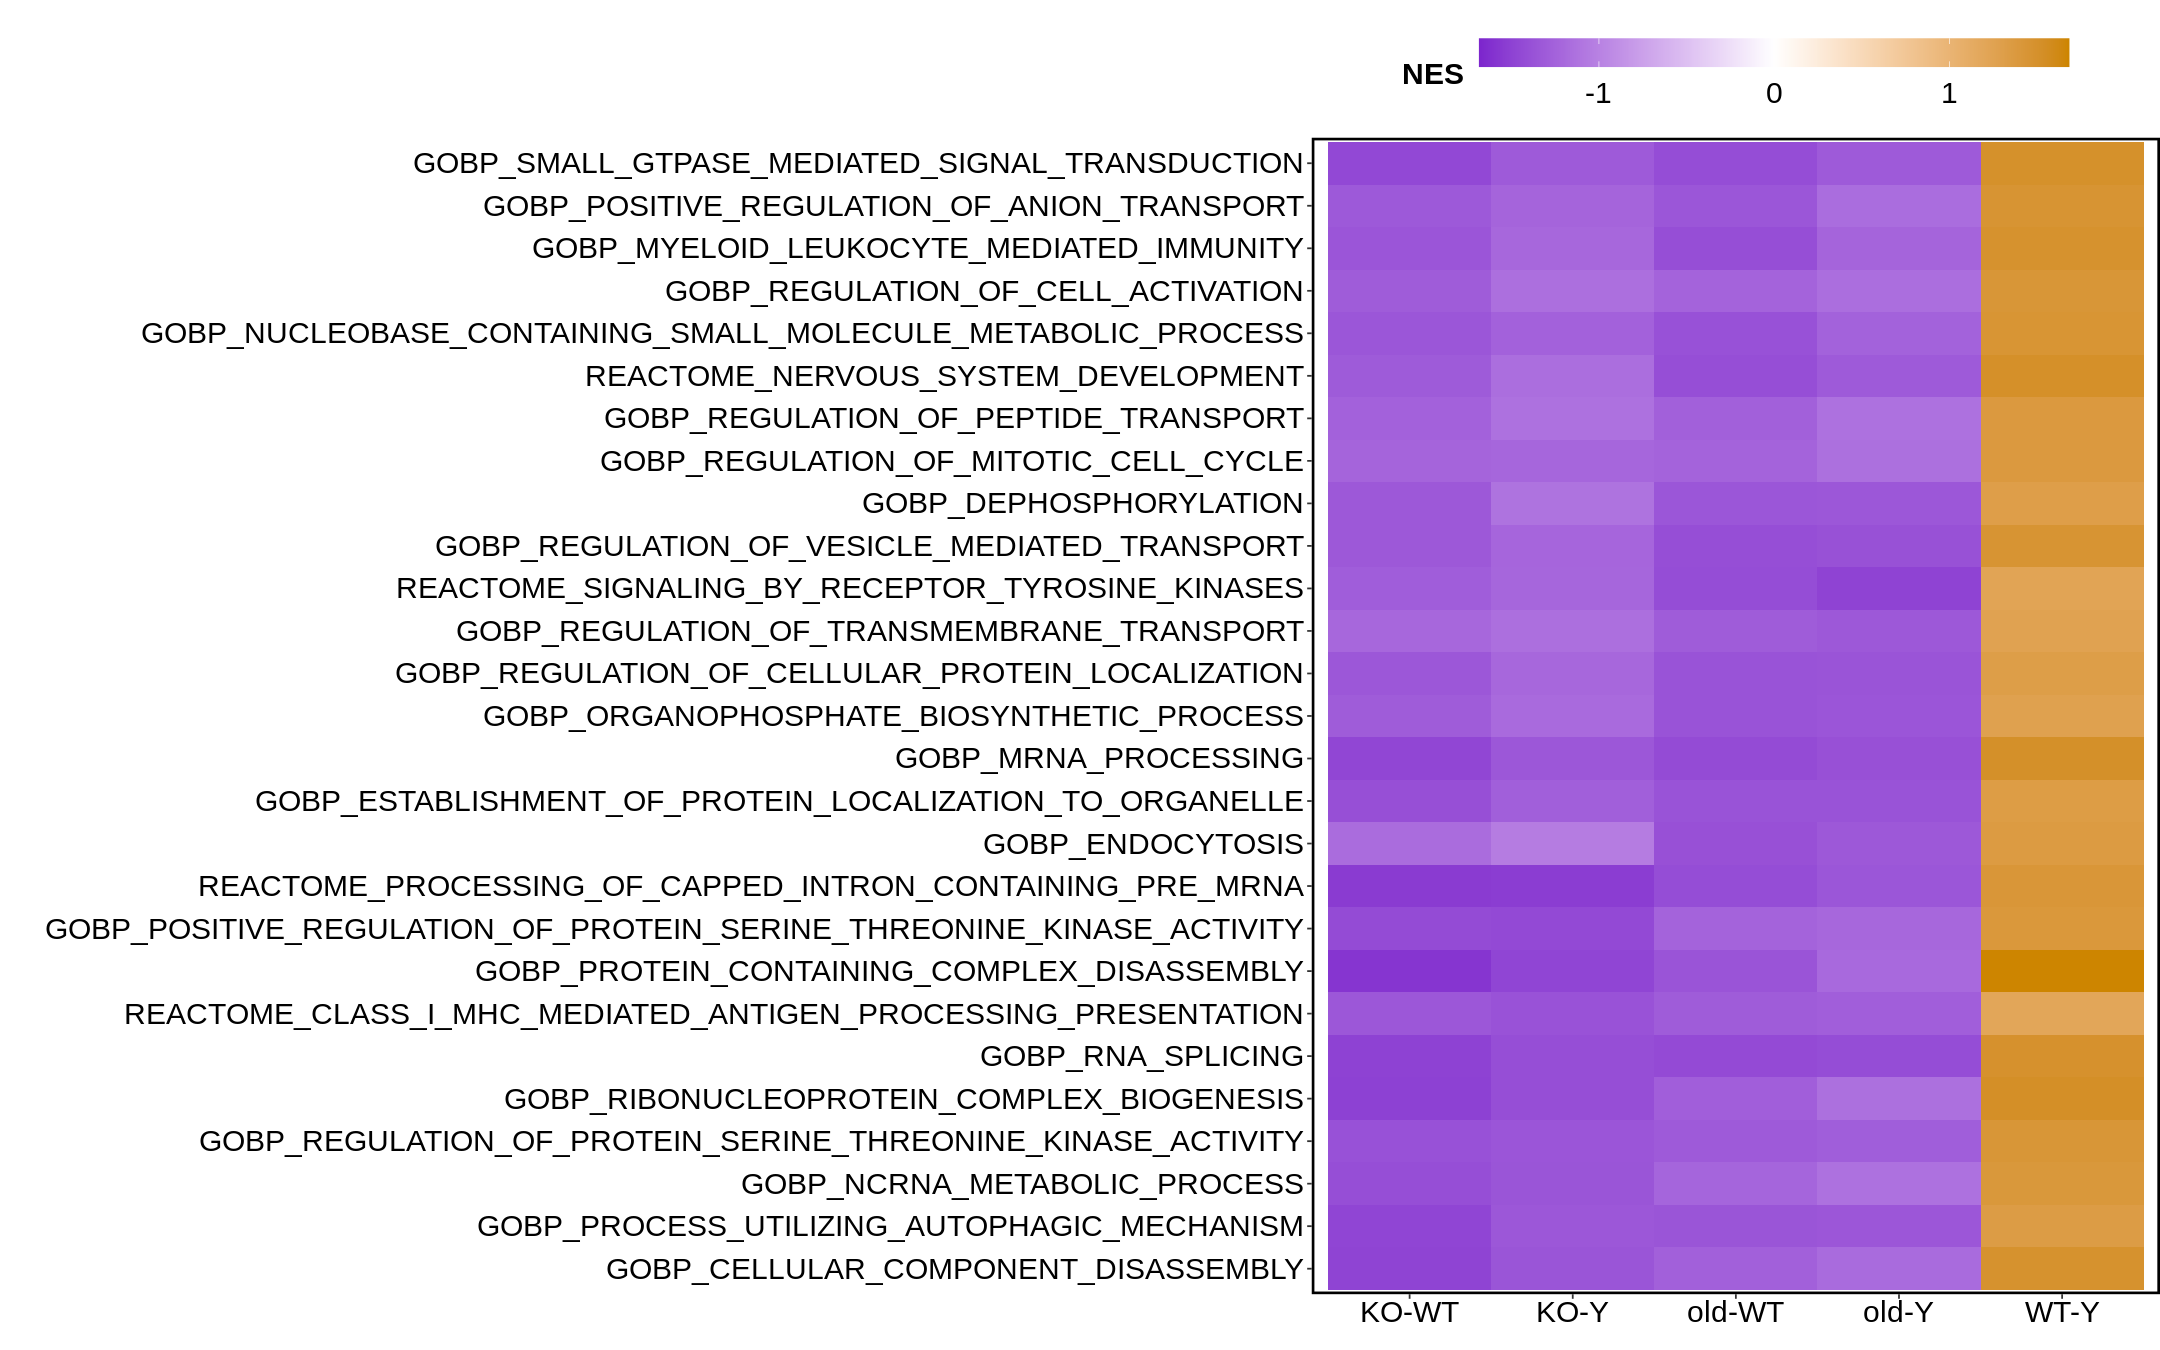

In [326]:
fontsize=18
limit <- max(abs(submelt$NES))
options(repr.plot.width = 18, repr.plot.height = nrow(submelt)/3/4)
ggplot(data=submelt, aes(x=type, y=pathway, fill=NES)) + 
    geom_tile()+
    theme(
        axis.text.y = element_text(size = fontsize, colour='black'),
        axis.text.x = element_text(size = fontsize, colour='black'),
        panel.background = element_rect(fill='white', colour='black', size=1.5, linetype='solid'),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.title=element_text(size=fontsize, face = "bold"),
        legend.text=element_text(size=fontsize),
        legend.position="top", 
        legend.key.width = unit(2.5, "cm"),
        plot.margin = unit(c(0., 0., 0., 0.5), "cm")) +
    scale_fill_gradient2(
                        high="orange3", low="purple3", mid='white', 
                        limits=c(-limit, limit), 
                        midpoint=0)+
    labs(x="", y = "", title="")